In [ ]:
import tensorflow_datasets as tfds

(train_set, val_set, test_set), info = tfds.load(name="stanford_dogs", split=["train[:80%]","train[80%:]","test"],with_info=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
get_dog_name = info.features['label'].int2str

def plot_values(var, title=''):
    var_labels = pd.DataFrame({
    'label': [get_dog_name(i['label']) for i in var]
    })
    var_labels = var_labels.value_counts().reset_index()
    var_labels.columns=['Breeds','Counts']
    print(var_labels.info)
    plt.figure(figsize=(18,22))
    plt.title(title)
    plt.barh(var_labels['Breeds'], var_labels['Counts'])
    plt.yticks(fontsize=8)
    plt.show()

<bound method DataFrame.info of                                        Breeds  Counts
0                           n02111889-samoyed      88
1                            n02105251-briard      88
2                           n02101556-clumber      87
3                    n02102318-cocker_spaniel      87
4                        n02106550-rottweiler      87
..                                        ...     ...
115                           n02096177-cairn      73
116  n02093428-american_staffordshire_terrier      73
117                       n02085620-chihuahua      72
118                 n02097474-tibetan_terrier      72
119              n02107312-miniature_pinscher      70

[120 rows x 2 columns]>


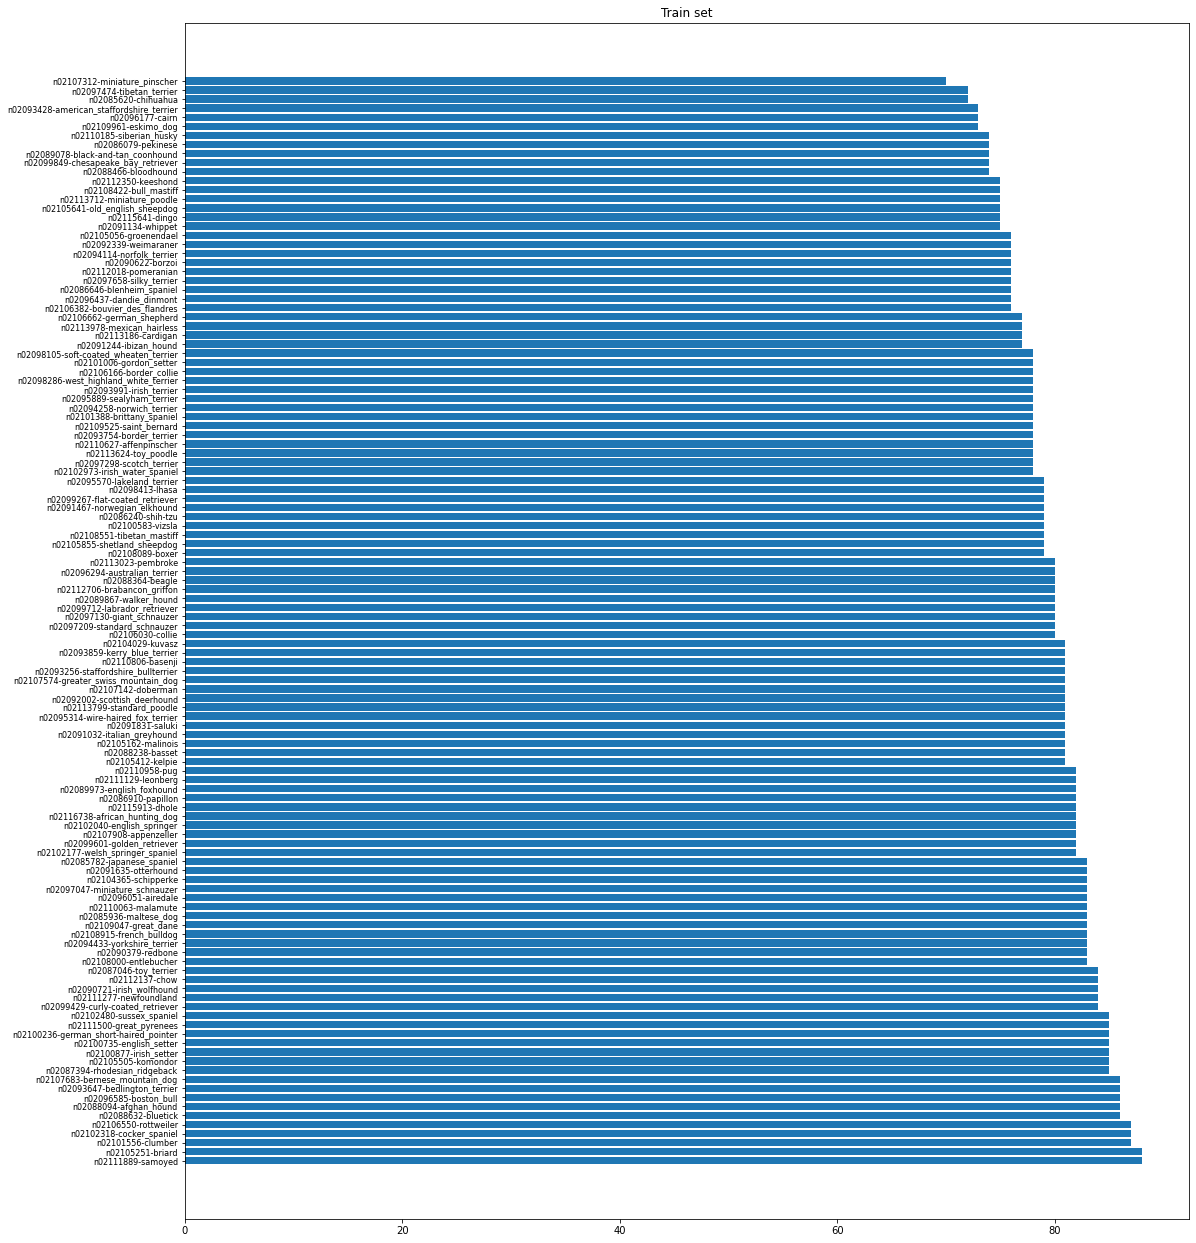

In [ ]:
plot_values(train_set, 'Train set')

<bound method DataFrame.info of                                        Breeds  Counts
0                n02107312-miniature_pinscher      30
1                         n02085620-chihuahua      28
2                   n02097474-tibetan_terrier      28
3    n02093428-american_staffordshire_terrier      27
4                        n02109961-eskimo_dog      27
..                                        ...     ...
115                  n02102318-cocker_spaniel      13
116                         n02101556-clumber      13
117                      n02106550-rottweiler      13
118                         n02111889-samoyed      12
119                          n02105251-briard      12

[120 rows x 2 columns]>


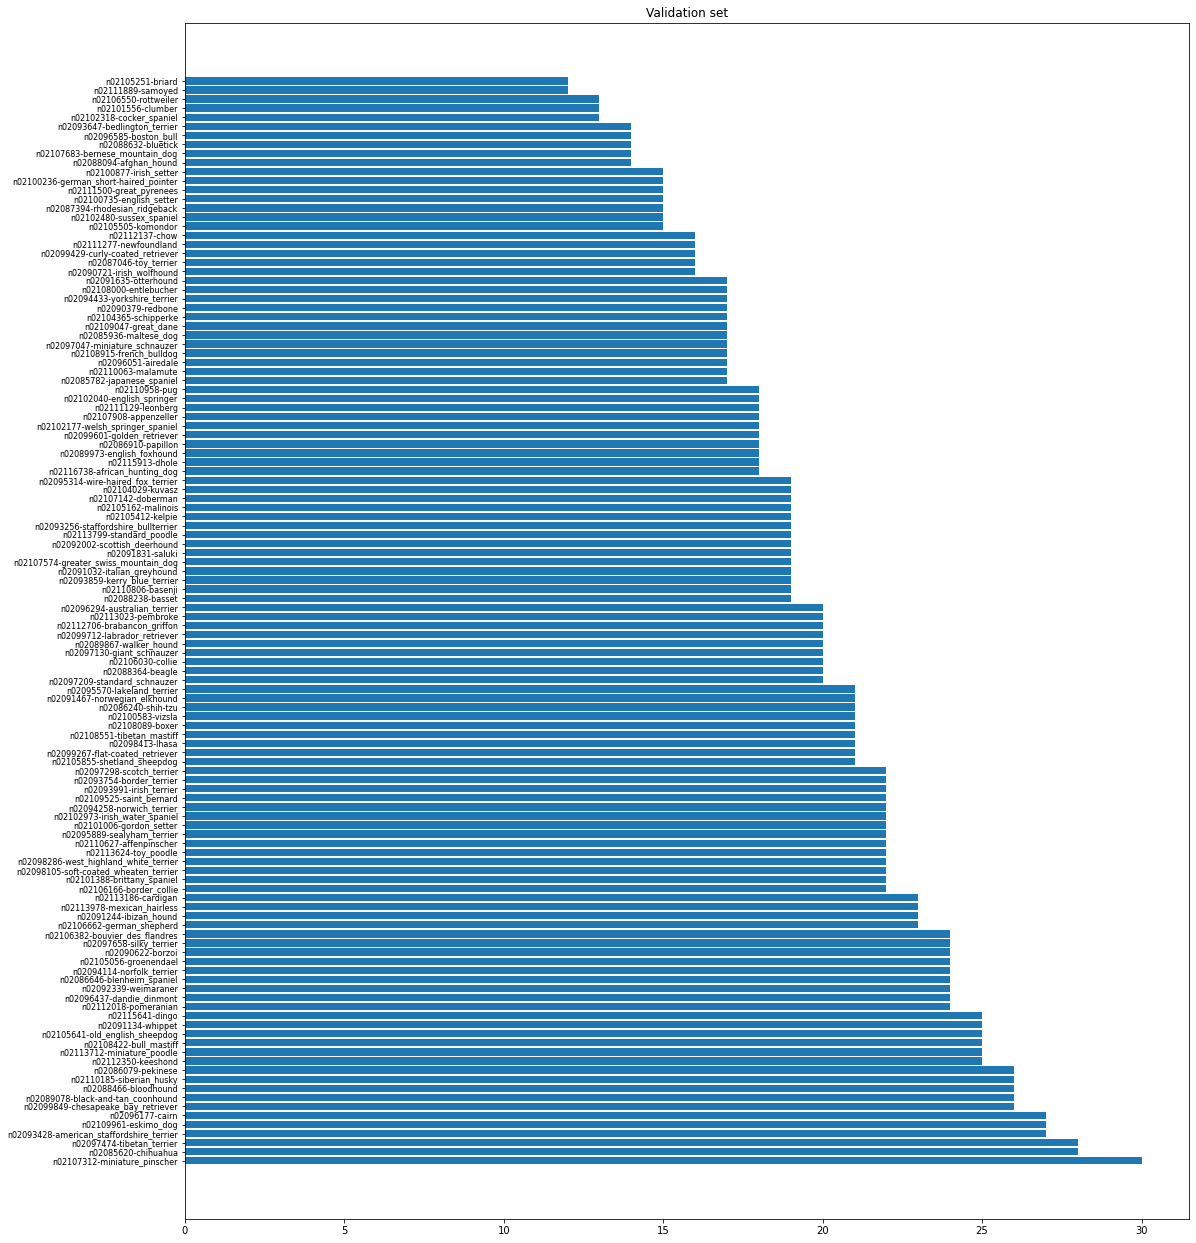

In [ ]:
plot_values(val_set, 'Validation set')

<bound method DataFrame.info of                              Breeds  Counts
0             n02085936-maltese_dog     152
1            n02088094-afghan_hound     139
2      n02092002-scottish_deerhound     132
3              n02112018-pomeranian     119
4    n02107683-bernese_mountain_dog     118
..                              ...     ...
115   n02102973-irish_water_spaniel      50
116         n02110627-affenpinscher      50
117  n02106382-bouvier_des_flandres      50
118              n02086079-pekinese      49
119               n02090379-redbone      48

[120 rows x 2 columns]>


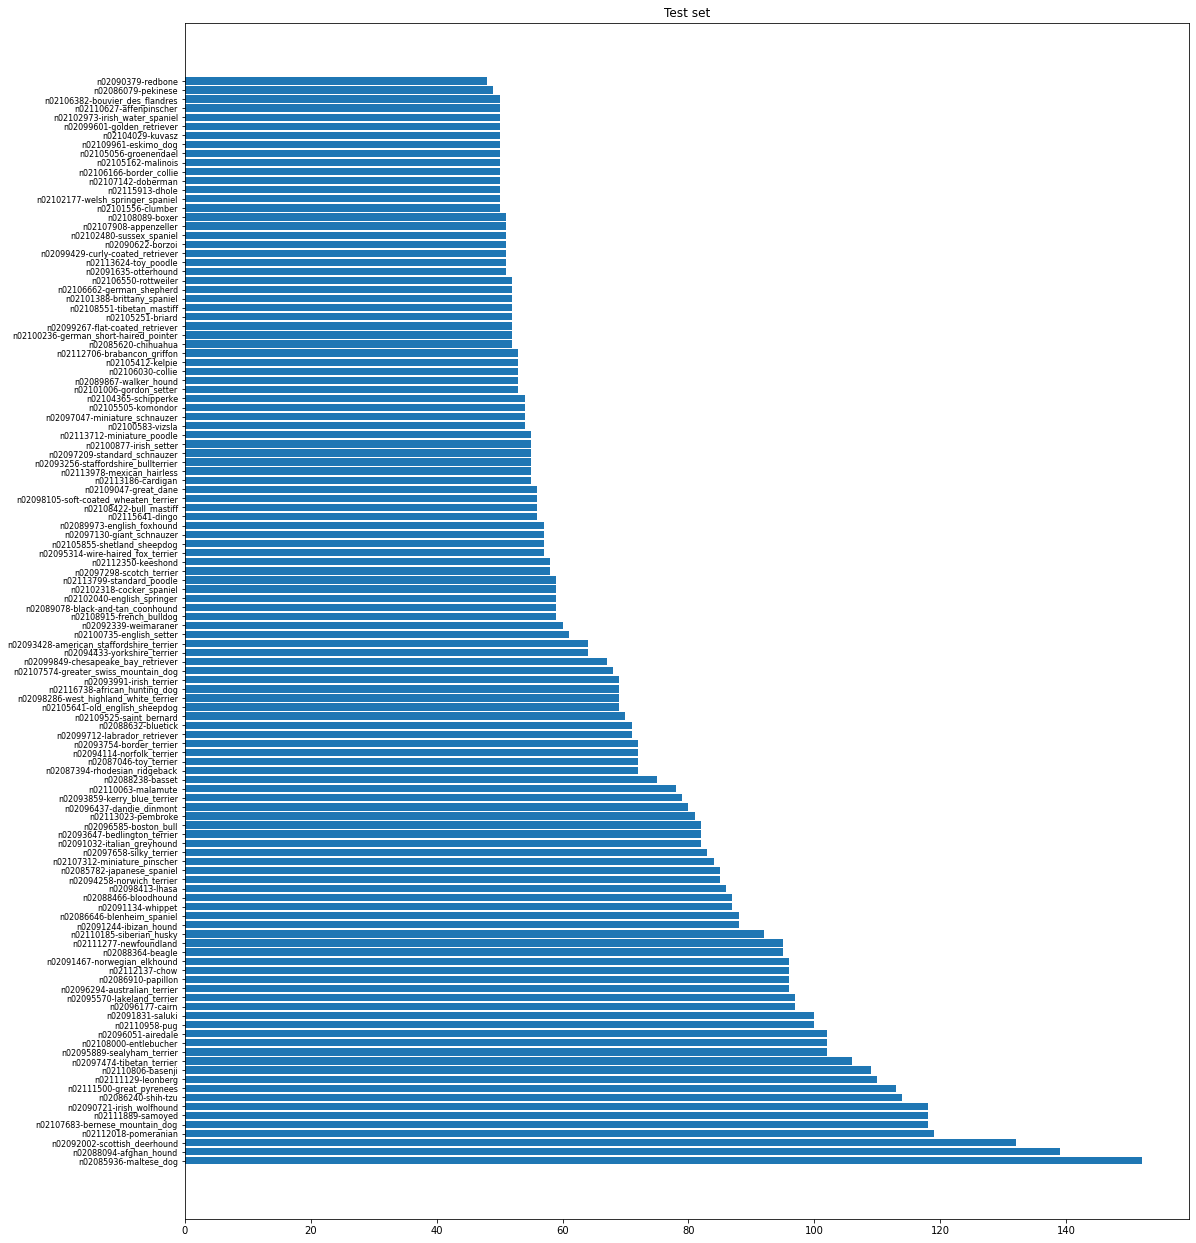

In [ ]:
plot_values(test_set, 'Test set')

In [ ]:
def plot_training(history):
    plt.subplot()
    plt.title('Model Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'])
    plt.show()

    plt.title('Model Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training Loss','Validation Loss'])
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_model(y_pred, y_true):
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(28,28))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Breed')
    ax.set_ylabel('Expected Breed');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(info.features["label"].names, rotation=90, fontsize=6)
    ax.yaxis.set_ticklabels(info.features["label"].names, rotation=0, fontsize=6)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    ### Scores
    print('\n\n')
    print(classification_report(y_true, y_pred))

In [ ]:
from skimage import exposure
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
N_BREEDS = 120


def preprocess(ds_row):
  
    # Image conversion int->float + resizing
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
    image = tf.image.per_image_standardization(image)
    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'], N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def prepare_test(dataset, batch_size=None):
    # Identique à prepare mais sans le shuffle
    ds = dataset.map(preprocess, num_parallel_calls=4)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [earlystop, reduceLR]

In [ ]:
print("[INFO] creating model...")
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=IMG_SHAPE))
base_model.trainable = False
model = tf.keras.Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dropout(0.4),
  Dense(N_BREEDS, activation='softmax')
])

print("[INFO] compiling model...")
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("[INFO] training head...")
train_batches = prepare(train_set, batch_size=32)
val_batches = prepare(val_set, batch_size=32)

history = model.fit(
    train_batches,
    epochs=30,
    validation_data=val_batches,
    callbacks= callbacks,
    verbose=1
)

[INFO] creating model...
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
300/300 [==============================] - 30s 83ms/step - loss: 4.7226 - accuracy: 0.0580 - val_loss: 3.6299 - val_accuracy: 0.2483 - lr: 1.0000e-04
Epoch 2/30
300/300 [==============================] - 25s 79ms/step - loss: 3.4793 - accuracy: 0.2311 - val_loss: 2.8720 - val_accuracy: 0.3804 - lr: 1.0000e-04
Epoch 3/30
300/300 [==============================] - 25s 78ms/step - loss: 2.8490 - accuracy: 0.3380 - val_loss: 2.5007 - val_accuracy: 0.4296 - lr: 1.0000e-04
Epoch 4/30
300/300 [==============================] - 25s 78ms/step - loss: 2.4900 - accuracy: 0.4050 - val_loss: 2.3135 - val_accuracy: 0.4525 - lr: 1.0000e-04
Epoch 5/30
300/300 [==============================] - 25s 79ms/step - loss: 2.2705 - accuracy: 0.4411 - val_loss: 2.2049 - val_accuracy: 0.4646 - lr: 1.0000e-04
Epoch 6/30
300/300 [==============================] - 25s 79ms/step - loss: 2.1337 - accuracy: 0.4671 - val_loss: 2.1347

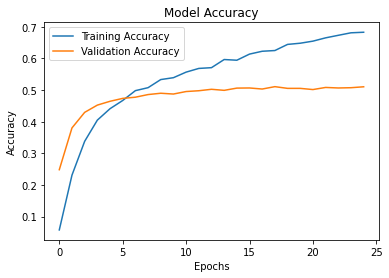

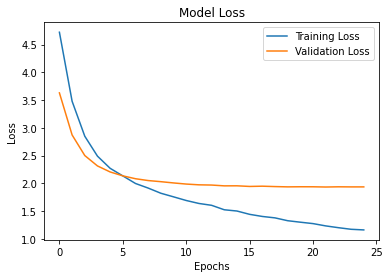

In [ ]:
plot_training(history)

[INFO] evaluating scratch model...
269/269 [==============================] - 17s 57ms/step


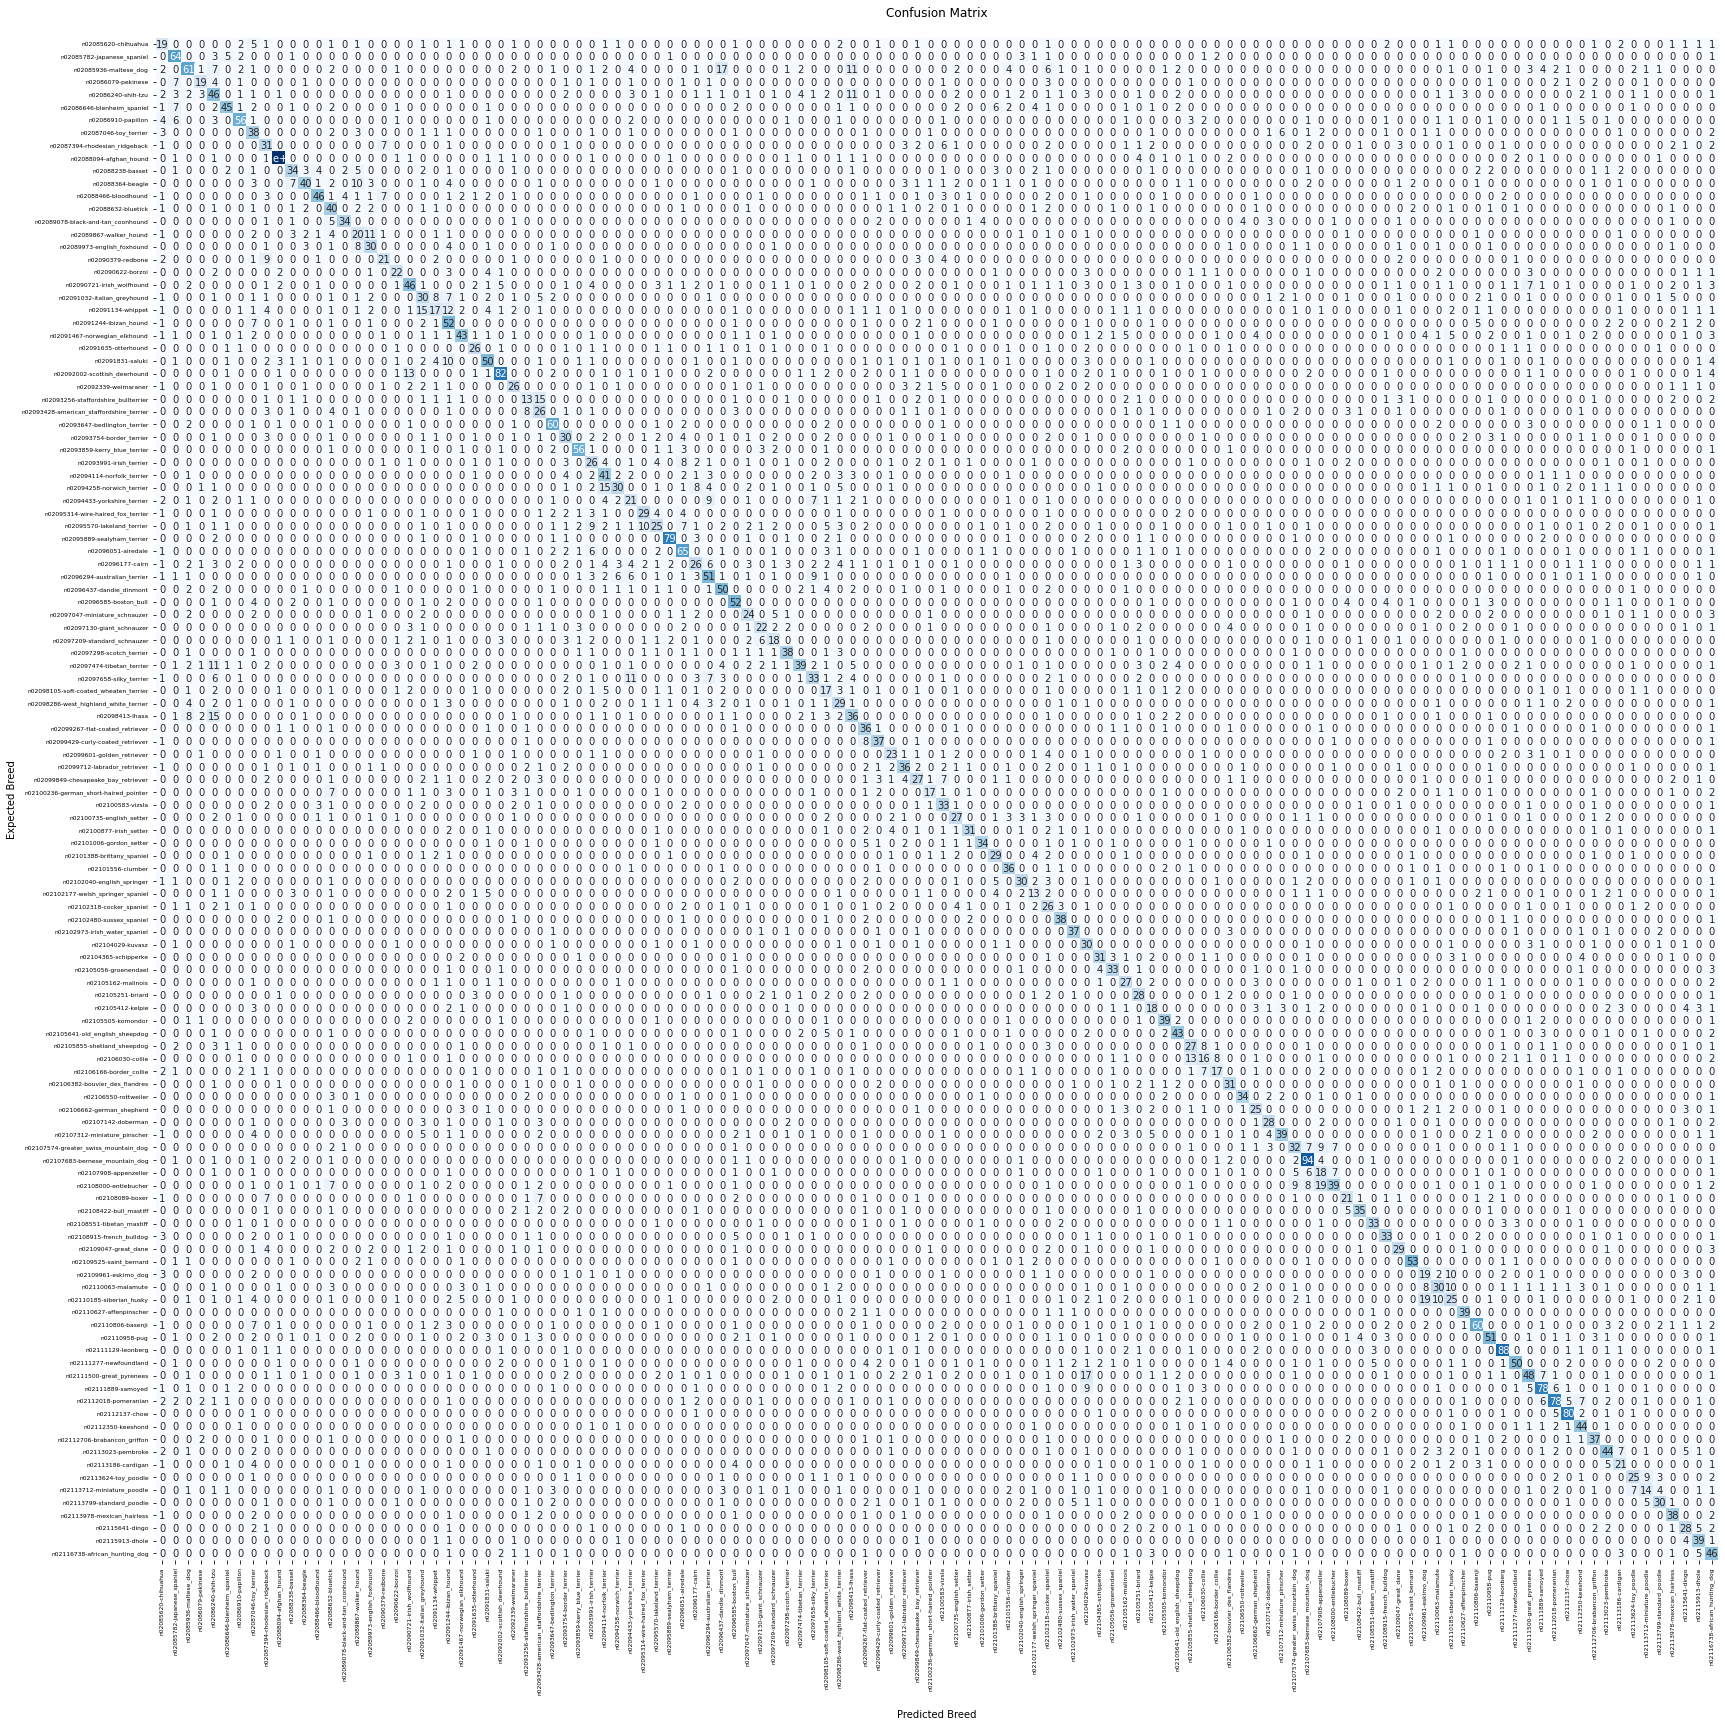




              precision    recall  f1-score   support

           0       0.27      0.37      0.31        52
           1       0.60      0.75      0.67        85
           2       0.60      0.40      0.48       152
           3       0.56      0.39      0.46        49
           4       0.33      0.40      0.36       114
           5       0.67      0.51      0.58        88
           6       0.64      0.58      0.61        96
           7       0.32      0.53      0.40        72
           8       0.35      0.43      0.39        72
           9       0.83      0.81      0.82       139
          10       0.50      0.45      0.48        75
          11       0.70      0.42      0.53        95
          12       0.74      0.53      0.62        87
          13       0.35      0.56      0.43        71
          14       0.77      0.58      0.66        59
          15       0.33      0.38      0.35        53
          16       0.48      0.53      0.50        57
          17       0.53 

In [ ]:
import numpy as np

print("[INFO] evaluating scratch model...")
test_batches = prepare_test(test_set, batch_size=32)
pred = model.predict(test_batches, verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)
y_true = np.array(list(map(lambda x: x['label'].numpy(), test_set)))
evaluate_model(predicted_class_indices, y_true)

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [ ]:
print("[INFO] unfreezing last block...")

state = False
for layer in base_model.layers:
    layer.trainable = state
    if layer.name.__contains__('mixed9'):
        state = True
for layer in base_model.layers:
    print(f'{layer.name}: {layer.trainable}')
print(model.summary)
print("[INFO] re-compiling model...")
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.00001),
    metrics=["accuracy"])

print("[INFO] training head...")
history = model.fit(
    train_batches,
    epochs=30,
    validation_data=test_batches,
    callbacks= callbacks,
    verbose=1
)

[INFO] unfreezing last block...
input_4: False
conv2d_282: False
batch_normalization_282: False
activation_282: False
conv2d_283: False
batch_normalization_283: False
activation_283: False
conv2d_284: False
batch_normalization_284: False
activation_284: False
max_pooling2d_12: False
conv2d_285: False
batch_normalization_285: False
activation_285: False
conv2d_286: False
batch_normalization_286: False
activation_286: False
max_pooling2d_13: False
conv2d_290: False
batch_normalization_290: False
activation_290: False
conv2d_288: False
conv2d_291: False
batch_normalization_288: False
batch_normalization_291: False
activation_288: False
activation_291: False
average_pooling2d_27: False
conv2d_287: False
conv2d_289: False
conv2d_292: False
conv2d_293: False
batch_normalization_287: False
batch_normalization_289: False
batch_normalization_292: False
batch_normalization_293: False
activation_287: False
activation_289: False
activation_292: False
activation_293: False
mixed0: False
conv2d_297:

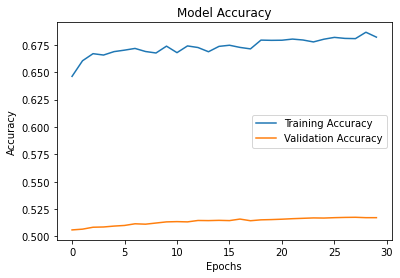

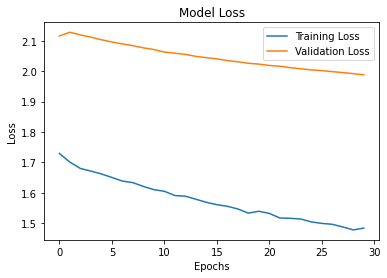

In [ ]:
plot_training(history)

[INFO] evaluating scratch model...
269/269 [==============================] - 16s 56ms/step


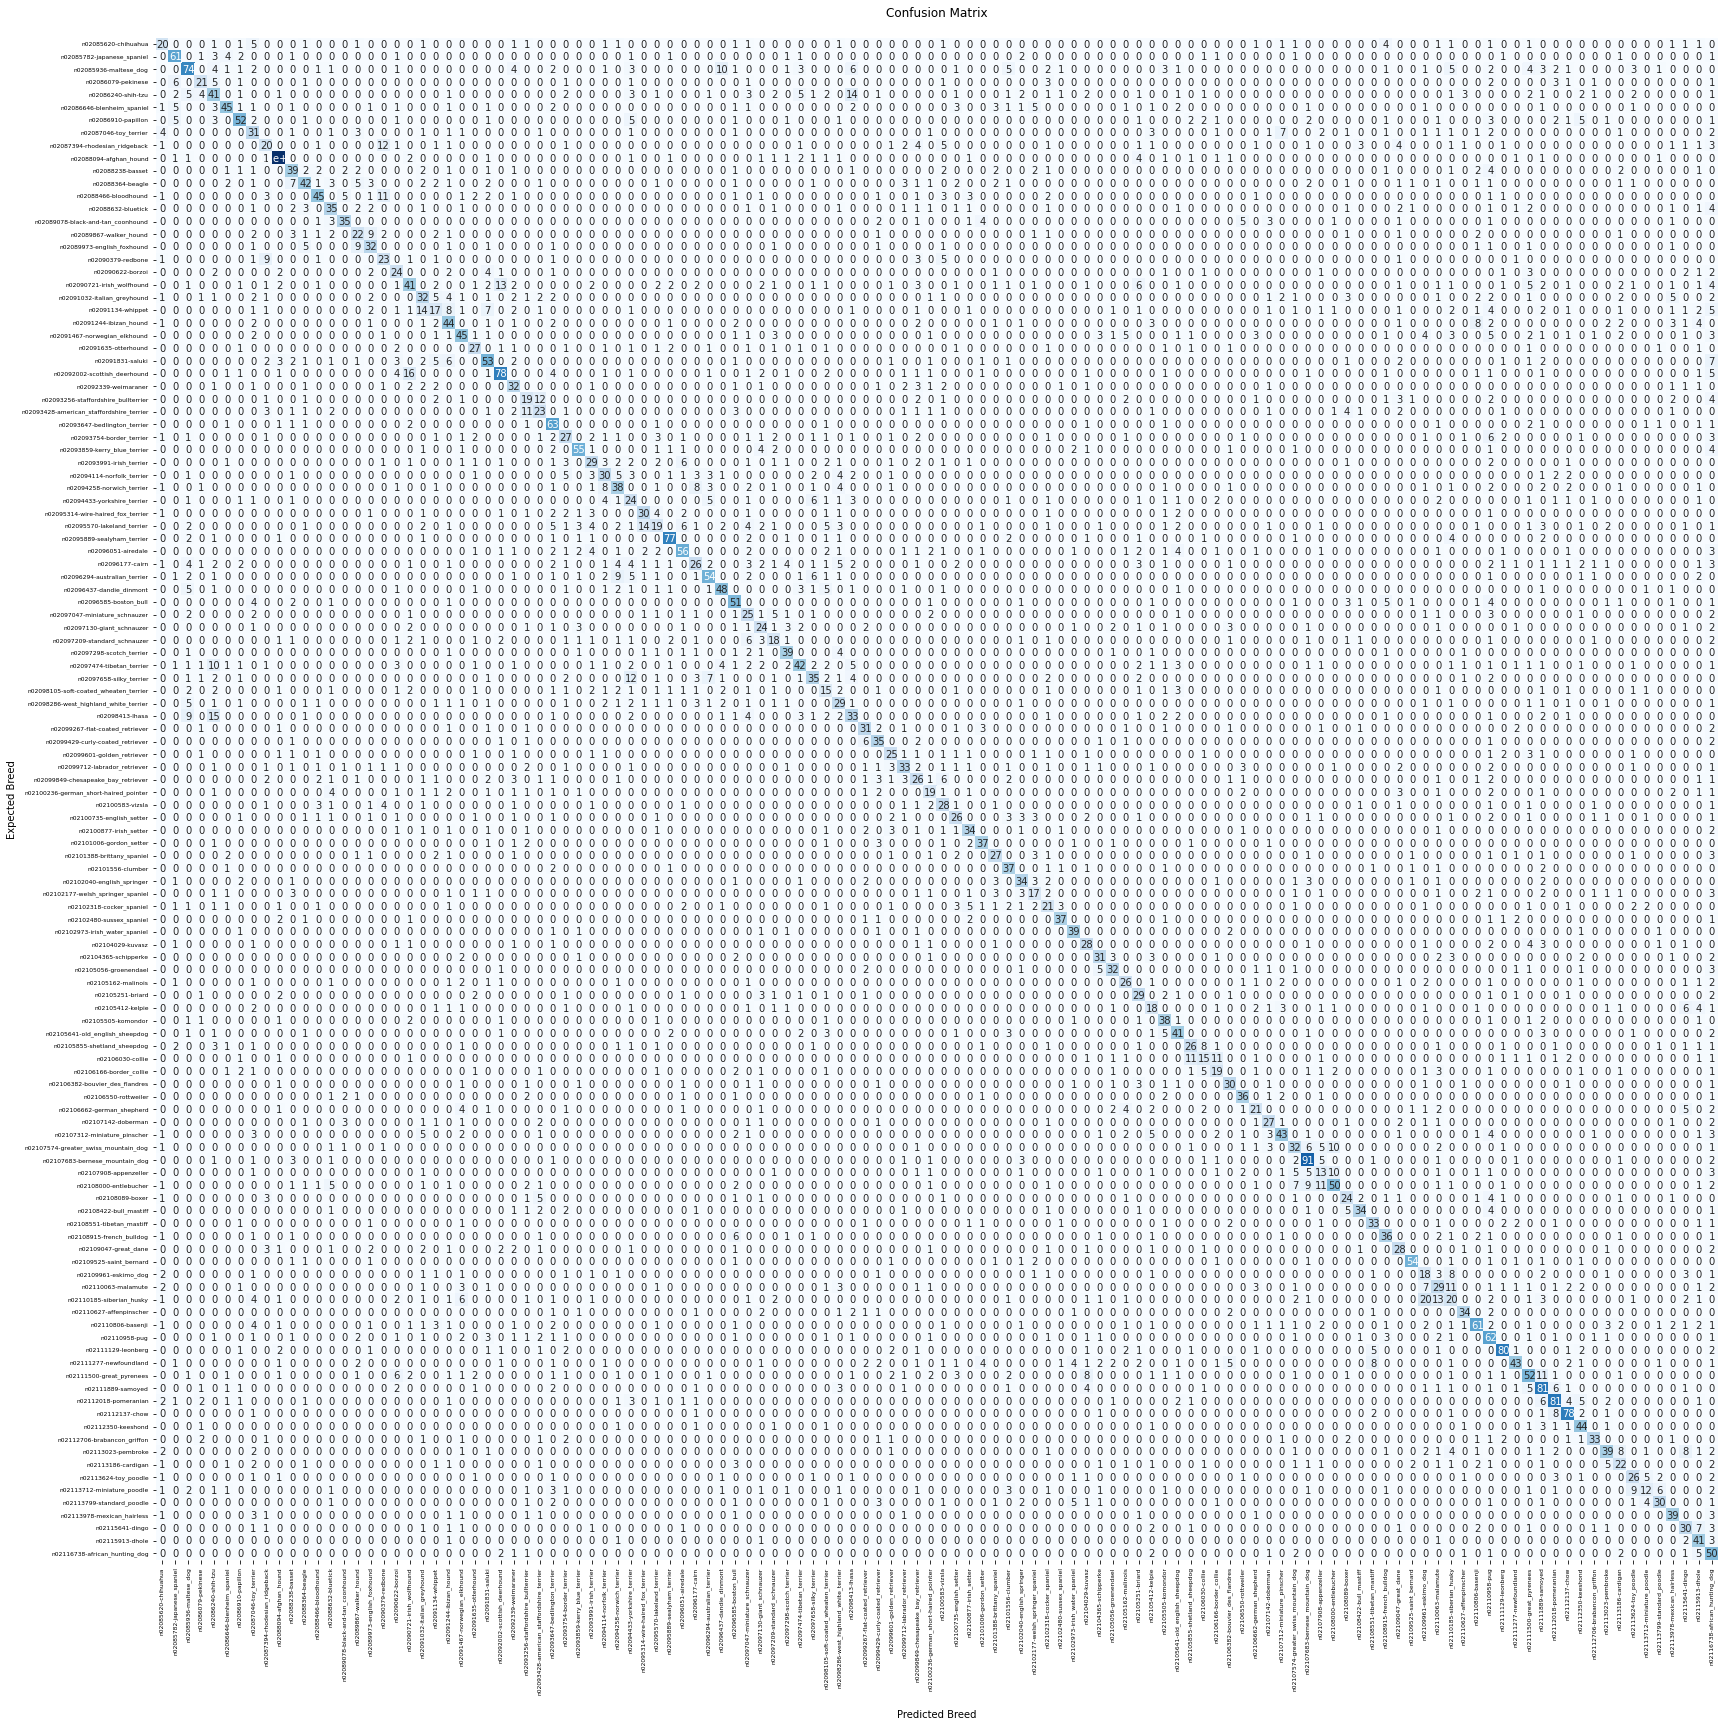




              precision    recall  f1-score   support

           0       0.38      0.38      0.38        52
           1       0.68      0.72      0.70        85
           2       0.59      0.49      0.53       152
           3       0.51      0.43      0.47        49
           4       0.37      0.36      0.36       114
           5       0.65      0.51      0.57        88
           6       0.64      0.54      0.59        96
           7       0.32      0.43      0.37        72
           8       0.35      0.28      0.31        72
           9       0.78      0.80      0.79       139
          10       0.51      0.52      0.51        75
          11       0.58      0.44      0.50        95
          12       0.69      0.52      0.59        87
          13       0.50      0.49      0.50        71
          14       0.71      0.59      0.65        59
          15       0.42      0.42      0.42        53
          16       0.48      0.56      0.52        57
          17       0.40 

In [ ]:
print("[INFO] evaluating scratch model...")
pred = model.predict(test_batches, verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)
y_true = np.array(list(map(lambda x: x['label'].numpy(), test_set)))
evaluate_model(predicted_class_indices, y_true)

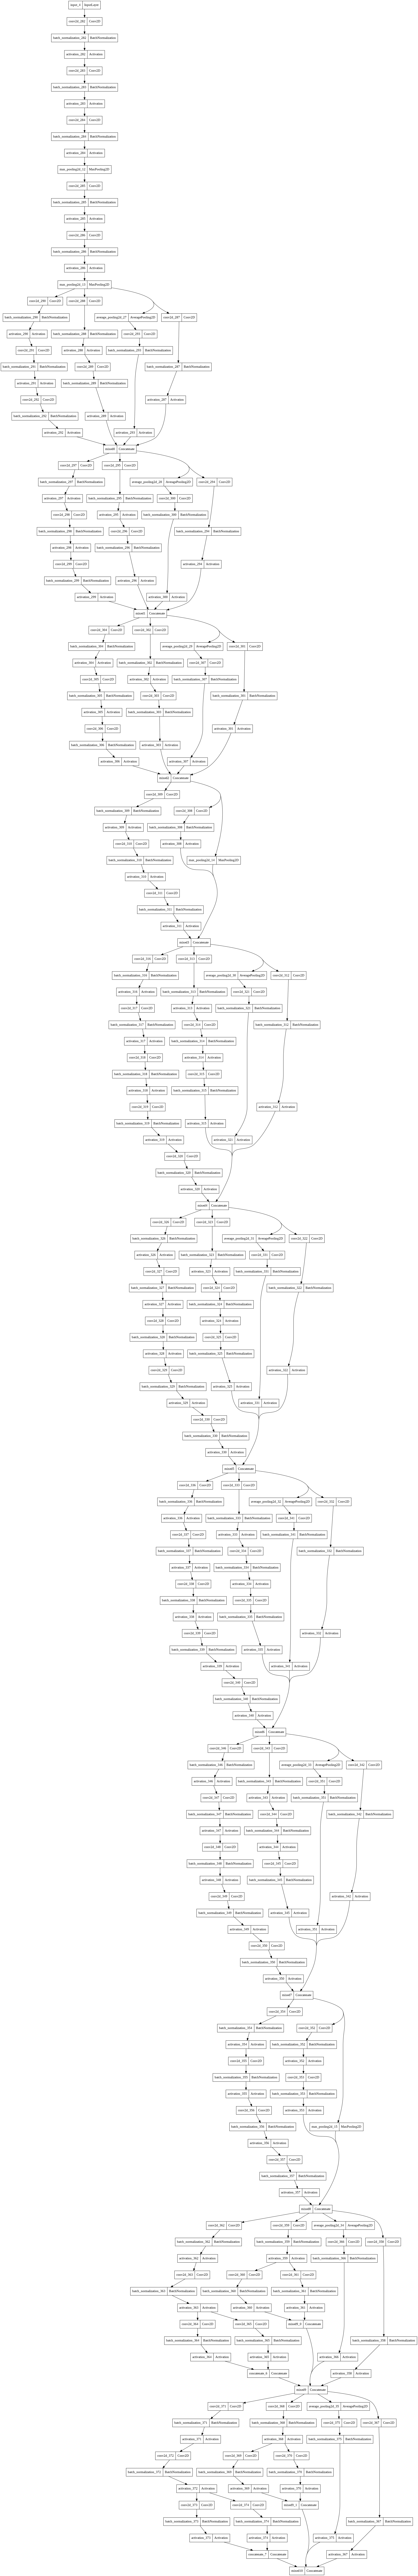

In [ ]:
plot_model(base_model)